In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import os
import pathlib
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
import cv2
import skimage
from skimage.util import random_noise
import tensorflow as tf
from google.colab import files

from tqdm.notebook import tqdm
import random

In [ ]:
# Get gt_images in memory
def get_images_in_mem(img_path):
    images_lst = []

    img = cv2.imread(img_path)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))
    images_lst.append(img)
    return np.array(images_lst)

In [ ]:
noisy_train_images = get_images_in_mem("noisy.jpg")
noisy_test_images = get_images_in_mem("noisy.jpg")

gt_train_images = get_images_in_mem("ori.jpg") #original_image
gt_test_images = get_images_in_mem("ori.jpg")

print(noisy_train_images.shape)
print(noisy_test_images.shape)

print(gt_train_images.shape)
print(gt_test_images.shape)

In [ ]:
f, axarr = plt.subplots(1,2, figsize=(14,14))
axarr[0].imshow(noisy_train_images[0])
axarr[0].set_title("Noisy image")
axarr[1].imshow(gt_train_images[0])
axarr[1].title.set_text("Ground Truth image")

In [ ]:
def _up_down_flip(image, label):
    image = tf.image.flip_up_down(image)
    label = tf.image.flip_up_down(label)
    return image, label

def _left_right_flip(image, label):
    image = tf.image.flip_left_right(image)
    label = tf.image.flip_left_right(label)
    return image, label

def _rotate(image, label):
    random_angle = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, random_angle)
    label = tf.image.rot90(label, random_angle)
    return image, label

def _hue(image, label):
    rand_value = random.uniform(-1,1)
    image = tf.image.adjust_hue(image, rand_value)
    label = tf.image.adjust_hue(label, rand_value)
    return image, label

def _brightness(image, label):
    rand_value = random.uniform(-0.08,0.25)
    image = tf.image.adjust_brightness(image, rand_value)
    label = tf.image.adjust_brightness(label, rand_value)
    return image, label

def _saturation(image, label):
    rand_value = random.uniform(1, 5)
    image = tf.image.adjust_saturation(image, rand_value)
    label = tf.image.adjust_saturation(label, rand_value)
    return image, label

def _contrast(image, label):
    rand_value = random.uniform(1, 3)
    image = tf.image.adjust_contrast(image, rand_value)
    label = tf.image.adjust_contrast(label, rand_value)
    return image, label
# What does batch, repeat, and shuffle do with TensorFlow Dataset?
# https://stackoverflow.com/q/53514495/7697658
def tf_data_generator(X, y, batch_size=32, augmentations=None):
    dataset = tf.data.Dataset.from_tensor_slices((X, y)) # This is the main step for data generation
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)

    if augmentations:
        for f in augmentations:
            if np.random.uniform(0,1)<0.5:
                dataset = dataset.map(f, num_parallel_calls=2)
    dataset = dataset.cache()
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

BATCH_SIZE=4
augmentation_lst = [_up_down_flip, _left_right_flip, _rotate]
image_generator_train = tf_data_generator(X=noisy_train_images, y=gt_train_images, batch_size=BATCH_SIZE, augmentations=augmentation_lst)
image_generator_test = tf_data_generator(X=noisy_test_images, y=gt_test_images, batch_size=BATCH_SIZE)

In [ ]:
image_generator_train

<PrefetchDataset element_spec=(TensorSpec(shape=(4, 256, 256, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(4, 256, 256, 3), dtype=tf.uint8, name=None))>

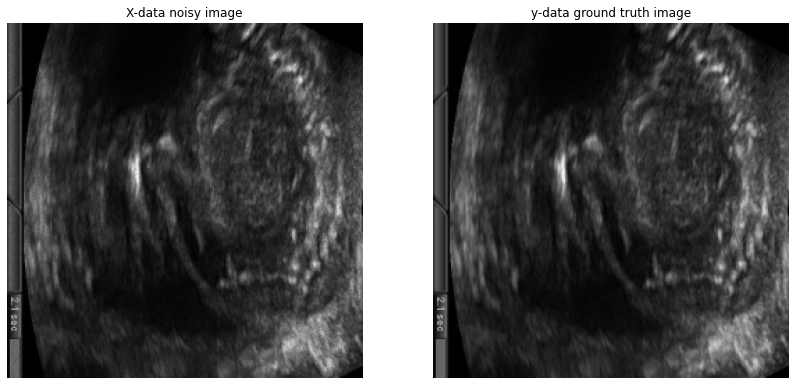

In [ ]:
# SANITY CHECK of the Dataset generator
for noisy, gt in image_generator_train.take(1):  # only take first element of dataset
    numpy_images = noisy.numpy()
    numpy_labels = gt.numpy()

f, axarr = plt.subplots(1,2, figsize=(14,14))
axarr[0].imshow(numpy_images[1])
axarr[0].set_title("X-data noisy image")
axarr[0].set_axis_off()

axarr[1].imshow(numpy_labels[1])
axarr[1].set_title("y-data ground truth image")
axarr[1].set_axis_off()

In [ ]:
steps_per_epoch_train = len(noisy_train_images)
steps_per_epoch_validation = len(noisy_test_images)

In [ ]:
# Inference
def inference_single_image(model, noisy_image):
    input_image = np.expand_dims(noisy_image, axis=0)
    predicted_image = model.predict(input_image)
    
    return predicted_image[0]

In [ ]:
def inference_batch_images(model, noisy_images):
    predicted_image = model.predict(noisy_images, batch_size=4)
    return predicted_image

In [ ]:
def visualize_predictions(model, X_test, y_test, n):
    random_numbers = random.choices(range(X_test.shape[0]), k=n)    # Get n random indices
    if(1):
        noisy_image = X_test[0]
        gt_image = y_test[0]
        predicted_image = inference_single_image(model, X_test[0])
        predicted_image/=255
       #files.download( "predicted_image.png" ) 

        f, axarr = plt.subplots(1,3, figsize=(21,21))
        axarr[0].imshow(noisy_image)
        axarr[0].set_title("Noisy image")
        axarr[0].set_axis_off()
        axarr[1].imshow(gt_image)
        axarr[1].set_title("Ground truth image")
        axarr[1].set_axis_off()
        axarr[2].imshow(predicted_image)
        axarr[2].set_title("Predicted image")
        axarr[2].set_axis_off()
        #axarr[2].imsave(predicted_image)

In [ ]:
#####################################       PRIDNET    ####################################################
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,\
                                    GlobalAveragePooling2D, AveragePooling2D, MaxPool2D, UpSampling2D,\
                                    BatchNormalization, Activation, Flatten, Dense, Input,\
                                    Add, Multiply, Concatenate, concatenate, Softmax
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import softmax
from keras.models import Sequential

tf.keras.backend.set_image_data_format('channels_last')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.nn import init

In [ ]:
class Convolutional_block(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')
        self.conv_2 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')
        self.conv_3 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')
        self.conv_4 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')

    def call(self, X):
        X_1 = self.conv_1(X)
        X_1 = Activation('relu')(X_1)

        X_2 = self.conv_2(X_1)
        X_2 = Activation('relu')(X_2)

        X_3 = self.conv_3(X_2)
        X_3 = Activation('relu')(X_3)

        X_4 = self.conv_4(X_3)
        X_4 = Activation('relu')(X_4)

        #visualize_predictions(model, noisy_test_images, gt_test_images, 1)
        print('---conv block=',X_4.shape)
        
        return X_4

In [ ]:
class Channel_attention(tf.keras.layers.Layer):
    def __init__(self, C=64, **kwargs):
        super().__init__(**kwargs)
        self.C=C
        self.gap = GlobalAveragePooling2D()
        self.dense_middle = Dense(units=2, activation='relu', use_bias=False)
        self.dense_sigmoid = Dense(units=self.C, activation='sigmoid', use_bias = False)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'C': self.C
        })
        return config

    def call(self, X):
        v = self.gap(X)
        #print("ca_ after gap =",v.shape)
        fc1 = self.dense_middle(v)
        #print("ca_ after fc1 =",fc1.shape)
        mu = self.dense_sigmoid(fc1)
        #print("ca_ after fc2 =",mu.shape)

        U_out = Multiply()([X, mu])
        
        #print('---channel attention block=',U_out.shape)

        return U_out

In [ ]:
class BasicConv(tf.keras.layers.Layer):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

In [ ]:
class ChannelPool(tf.keras.layers.Layer):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

In [ ]:
class SpatialGate(tf.keras.layers.Layer):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
        Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')

    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out) # broadcasting
        return x * scale

In [ ]:
class Avg_pool_Unet_Upsample_msfe(tf.keras.layers.Layer):
    def __init__(self, avg_pool_size, upsample_rate, **kwargs):
        super().__init__(**kwargs)
        # ---initialization for Avg pooling---
        self.avg_pool = AveragePooling2D(pool_size=avg_pool_size, padding='same')
        #print("avg_pool");

        # --- initialization for Unet---
        self.deconv_lst = []
        filter=512
        for i in range(4):
            self.deconv_lst.append(Conv2DTranspose(filters=filter/2, kernel_size=[3, 3], strides=2, padding='same'))
         #   print("Deconvl1");
            filter/=2

        self.conv_32_down_lst = []
        for i in range(4):
            self.conv_32_down_lst.append(Conv2D(filters=64, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))
         ##   print("conv_32_down_lst conv2d relu");

        self.conv_64_down_lst = []
        for i in range(4):
            self.conv_64_down_lst.append(Conv2D(filters=128, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))
         #   print("conv_64_down_lst conv2d relu");

        self.conv_128_down_lst = []
        for i in range(4):
            self.conv_128_down_lst.append(Conv2D(filters=256, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))
         #   print("conv_128_down_lst conv2d relu");

        self.conv_256_down_lst = []
        for i in range(4):
            self.conv_256_down_lst.append(Conv2D(filters=512, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))
         #   print("conv_256_down_lst conv2d relu");

        self.conv_512_down_lst = []
        for i in range(4):
            self.conv_512_down_lst.append(Conv2D(filters=1024, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))
         #   print("conv_512_down_lst conv2d relu");


        self.conv_32_up_lst = []
        for i in range(3):
            self.conv_32_up_lst.append(Conv2D(filters=64, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))
         #   print("conv_32_down_lst conv2d relu");

        self.conv_64_up_lst = []
        for i in range(3):
            self.conv_64_up_lst.append(Conv2D(filters=128, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))
         #   print("conv_64_down_lst conv2d relu");

        self.conv_128_up_lst = []
        for i in range(3):
            self.conv_128_up_lst.append(Conv2D(filters=256, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))
         #   print("conv_128_down_lst conv2d relu");

        self.conv_256_up_lst = []
        for i in range(3):
            self.conv_256_up_lst.append(Conv2D(filters=512, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))
          #  print("conv_256_down_lst conv2d relu");


        self.conv_3 = Conv2D(filters=3, kernel_size=[1, 1])

        self.pooling1_unet = MaxPool2D(pool_size=[2, 2], padding='same');print("max_pooling2d 1");
        self.pooling2_unet = MaxPool2D(pool_size=[2, 2], padding='same');print("max_pooling2d 2");
        self.pooling3_unet = MaxPool2D(pool_size=[2, 2], padding='same');print("max_pooling2d 3");
        self.pooling4_unet = MaxPool2D(pool_size=[2, 2], padding='same');print("max_pooling2d 4");

        # ---initialization for Upsampling---
        self.upsample = UpSampling2D(upsample_rate, interpolation='bilinear')
        #print("Upsample_bilinear")
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'avg_pool_size': self.avg_pool_size,
            'upsample_rate':self.upsample_rate
        })
        return config

    def upsample_and_concat(self, x1, x2, i):
        deconv = self.deconv_lst[i](x1)
        spa = SpatialGate()(x2)
        deconv_output = Concatenate()([deconv, spa])
        #print("upsample and concat()");
        return deconv_output

    def unet(self, input):
        # ---Unet downsampling---
        conv1 = input
        for c_32 in self.conv_32_down_lst:
            conv1 = c_32(conv1)
        pool1 = self.pooling1_unet(conv1)
        #print("downsample pool1");

        conv2 = pool1
        for c_64 in self.conv_64_down_lst:
            conv2 = c_64(conv2)
        pool2 = self.pooling2_unet(conv2)
        #print("downsample pool2");

        conv3 = pool2
        for c_128 in self.conv_128_down_lst:
            conv3 = c_128(conv3)
        pool3 = self.pooling3_unet(conv3)
        #print("downsample pool3");

        conv4 = pool3
        for c_256 in self.conv_256_down_lst:
            conv4 = c_256(conv4)
        pool4 = self.pooling4_unet(conv4)
        #print("downsample pool4");

        conv5 = pool4
        for c_512 in self.conv_512_down_lst:
            conv5 = c_512(conv5)
        #print("downsample pool5");
  
        # ---Unet upsampling---
        up6 = self.upsample_and_concat(conv5, conv4, 0)
        conv6 = up6
        for c_256 in self.conv_256_up_lst:
            conv6 = c_256(conv6)
        #print("upsample pool1");

        up7 = self.upsample_and_concat(conv6, conv3, 1)
        conv7 = up7
        for c_128 in self.conv_128_up_lst:
            conv7 = c_128(conv7)
        #print("upsample 128");

        up8 = self.upsample_and_concat(conv7, conv2, 2)
        conv8 = up8
        for c_64 in self.conv_64_up_lst:
            conv8 = c_64(conv8)
        #print("upsample 64");

        up9 = self.upsample_and_concat(conv8, conv1, 3)
        conv9 = up9
        for c_32 in self.conv_32_up_lst:
            conv9 = c_32(conv9)
        #print("upsample 32");

        conv10 = self.conv_3(conv9)
        return conv10

    def call(self, X):
        avg_pool = self.avg_pool(X)
        print("--------------------ap =",avg_pool.shape)
        unet = self.unet(avg_pool)
        print("--------------------unet",unet.shape);
        unet = SpatialGate()(unet)
        upsample = self.upsample(unet)
        print("-------------------upsample shape",upsample.shape)
        return upsample

#visualize_predictions(model, noisy_test_images, gt_test_images, 1)

In [ ]:
class Multi_scale_feature_extraction(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.msfe_16 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=16, upsample_rate=16)
        self.msfe_8 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=8, upsample_rate=8)
        self.msfe_4 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=4, upsample_rate=4)
        self.msfe_2 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=2, upsample_rate=2)
        self.msfe_1 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=1, upsample_rate=1)

    def call(self, X):
        up_sample_16 = self.msfe_16(X)
        up_sample_8 = self.msfe_8(X)
        up_sample_4 = self.msfe_4(X)
        up_sample_2 = self.msfe_2(X)
        up_sample_1 = self.msfe_1(X)
        msfe_out = Concatenate()([X, up_sample_16, up_sample_8, up_sample_4, up_sample_2, up_sample_1])
        
        #visualize_predictions(model, noisy_test_images, gt_test_images, 1)
        print('---Multi scale feature extraction block=',msfe_out.shape)
        return msfe_out

In [ ]:
class Kernel_selecting_module(tf.keras.layers.Layer):
    def __init__(self, C=21, **kwargs):
        super().__init__(**kwargs)
        self.C = C
        self.c_3 = Conv2D(filters=self.C, kernel_size=(3,3), strides=1, padding='same', kernel_regularizer=regularizers.l2(l2=0.001))
        self.c_5 = Conv2D(filters=self.C, kernel_size=(5,5), strides=1, padding='same', kernel_regularizer=regularizers.l2(l2=0.001))
        self.c_7 = Conv2D(filters=self.C, kernel_size=(7,7), strides=1, padding='same', kernel_regularizer=regularizers.l2(l2=0.001))
        self.gap = GlobalAveragePooling2D()
        self.dense_two = Dense(units=2, activation='relu')
        self.dense_c1 = Dense(units=self.C)
        self.dense_c2 = Dense(units=self.C)
        self.dense_c3 = Dense(units=self.C)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'C': self.C
        })
        return config

    def call(self, X):
        X_1 = self.c_3(X)
        X_2 = self.c_5(X)
        X_3 = self.c_7(X)

        X_dash = Add()([X_1, X_2, X_3])

        v_gap = self.gap(X_dash)
        v_gap = tf.reshape(v_gap, [-1, 1, 1, self.C])
        fc1 = self.dense_two(v_gap)

        alpha = self.dense_c1(fc1)
        beta = self.dense_c2(fc1)
        gamma = self.dense_c3(fc1)

        before_softmax = concatenate([alpha, beta, gamma], 1)
        print(before_softmax.shape)
        after_softmax = softmax(before_softmax, axis=1)
        a1 = after_softmax[:, 0, :, :]
        print(a1)
        a1 = tf.reshape(a1, [-1, 1, 1, self.C])
        print(a1)
        a2 = after_softmax[:, 1, :, :]
        a2 = tf.reshape(a2, [-1, 1, 1, self.C])
        a3 = after_softmax[:, 2, :, :]
        a3 = tf.reshape(a3, [-1, 1, 1, self.C])

        select_1 = Multiply()([X_1, a1])
        select_2 = Multiply()([X_2, a2])
        select_3 = Multiply()([X_3, a3])

        out = Add()([select_1, select_2, select_3])

        return out

In [ ]:
def create_model():
    # ca_block = Channel Attention block
    # msfe_block = Multi scale feature extraction block
    # ksm = Kernel Selecting Module
    tf.keras.backend.clear_session()

    input = Input(shape=(256,256,3), name="input_layer")
    print("Input =",input.shape)

    conv_block = Convolutional_block()(input)
    print("Conv block =",conv_block.shape)
    ca_block = Channel_attention()(conv_block)
    sa_block = SpatialGate()(conv_block)
    ca_block = Concatenate()([ca_block,sa_block])
    print("Channel Attention =",ca_block.shape)
#
    ca_block = Conv2D(filters=3, kernel_size=(3,3), strides=1, padding='same')(ca_block)
    ca_block = Conv2D(filters=3, kernel_size=(5,5), strides=1, padding='same')(ca_block)
    ca_block = Conv2D(filters=3, kernel_size=(7,7), strides=1, padding='same')(ca_block)
    ca_block = Conv2D(filters=3, kernel_size=(9,9), strides=1, padding='same')(ca_block)
#
    print("Channel Attention Last CNN =",ca_block.shape)
    ca_block = Concatenate()([input, ca_block])
    print("First phase =",ca_block.shape)
    print()

    #conv_layer_1 = Conv2D(filters=256, kernel_size=2, padding='same', name="conv_1")(ca_block)
    #conv_layer_2 = Conv2D(filters=256, kernel_size=2, padding='same', name="conv_2")(conv_layer_1)
    #conv_layer_3 = Conv2D(filters=256, kernel_size=3, padding='same', name="conv_3")(conv_layer_2)
    #conv_layer_4 = Conv2D(filters=256, kernel_size=3, padding='same', name="conv_4")(conv_layer_3)
    #conv_layer_5 = Conv2D(filters=128, kernel_size=3, padding='same', name="conv_5")(conv_layer_4)

    #deconv_layer_5 = Conv2DTranspose(filters=256, kernel_size=2, padding='same', name="deconv_5")(conv_layer_5)
    #deconv_layer_5 = Add(name="add_1")([conv_layer_4, deconv_layer_5])
    #deconv_layer_4 = Conv2DTranspose(filters=256, kernel_size=2, padding='same', name="deconv_4")(deconv_layer_5)
    #deconv_layer_3 = Conv2DTranspose(filters=256, kernel_size=3, padding='same', name="deconv_3")(deconv_layer_4)
    #deconv_layer_3 = Add(name="add_2")([conv_layer_2, deconv_layer_3])
    #deconv_layer_2 = Conv2DTranspose(filters=128, kernel_size=3, padding='same', name="deconv_2")(deconv_layer_3)
    #deconv_layer_1 = Conv2DTranspose(filters=3, kernel_size=3, padding='same', name="deconv_1")(deconv_layer_2)
    #out = Add(name="add_3")([input_0, deconv_layer_1])

    msfe_block = Multi_scale_feature_extraction()(ca_block)

    print("Multi-scale feature extraction =",msfe_block.shape)

    ksm = Kernel_selecting_module()(msfe_block)
    ksm = Conv2D(filters=3, kernel_size=(3,3), strides=1, padding='same')(ksm)
    print("Kernel Selection Module =",ksm.shape)
    model = Model(inputs=[input], outputs=[ksm])
    return model

model = create_model()
model.summary()

Input = (None, 256, 256, 3)
---conv block= (None, 256, 256, 64)
Conv block = (None, 256, 256, 64)
Channel Attention = (None, 256, 256, 128)
Channel Attention Last CNN = (None, 256, 256, 3)
First phase = (None, 256, 256, 6)

max_pooling2d 1
max_pooling2d 2
max_pooling2d 3
max_pooling2d 4
max_pooling2d 1
max_pooling2d 2
max_pooling2d 3
max_pooling2d 4
max_pooling2d 1
max_pooling2d 2
max_pooling2d 3
max_pooling2d 4
max_pooling2d 1
max_pooling2d 2
max_pooling2d 3
max_pooling2d 4
max_pooling2d 1
max_pooling2d 2
max_pooling2d 3
max_pooling2d 4
--------------------ap = (None, 16, 16, 6)
--------------------unet (None, 16, 16, 3)
-------------------upsample shape (None, 256, 256, 3)
--------------------ap = (None, 32, 32, 6)
--------------------unet (None, 32, 32, 3)
-------------------upsample shape (None, 256, 256, 3)
--------------------ap = (None, 64, 64, 6)
--------------------unet (None, 64, 64, 3)
-------------------upsample shape (None, 256, 256, 3)
--------------------ap = (None, 128,

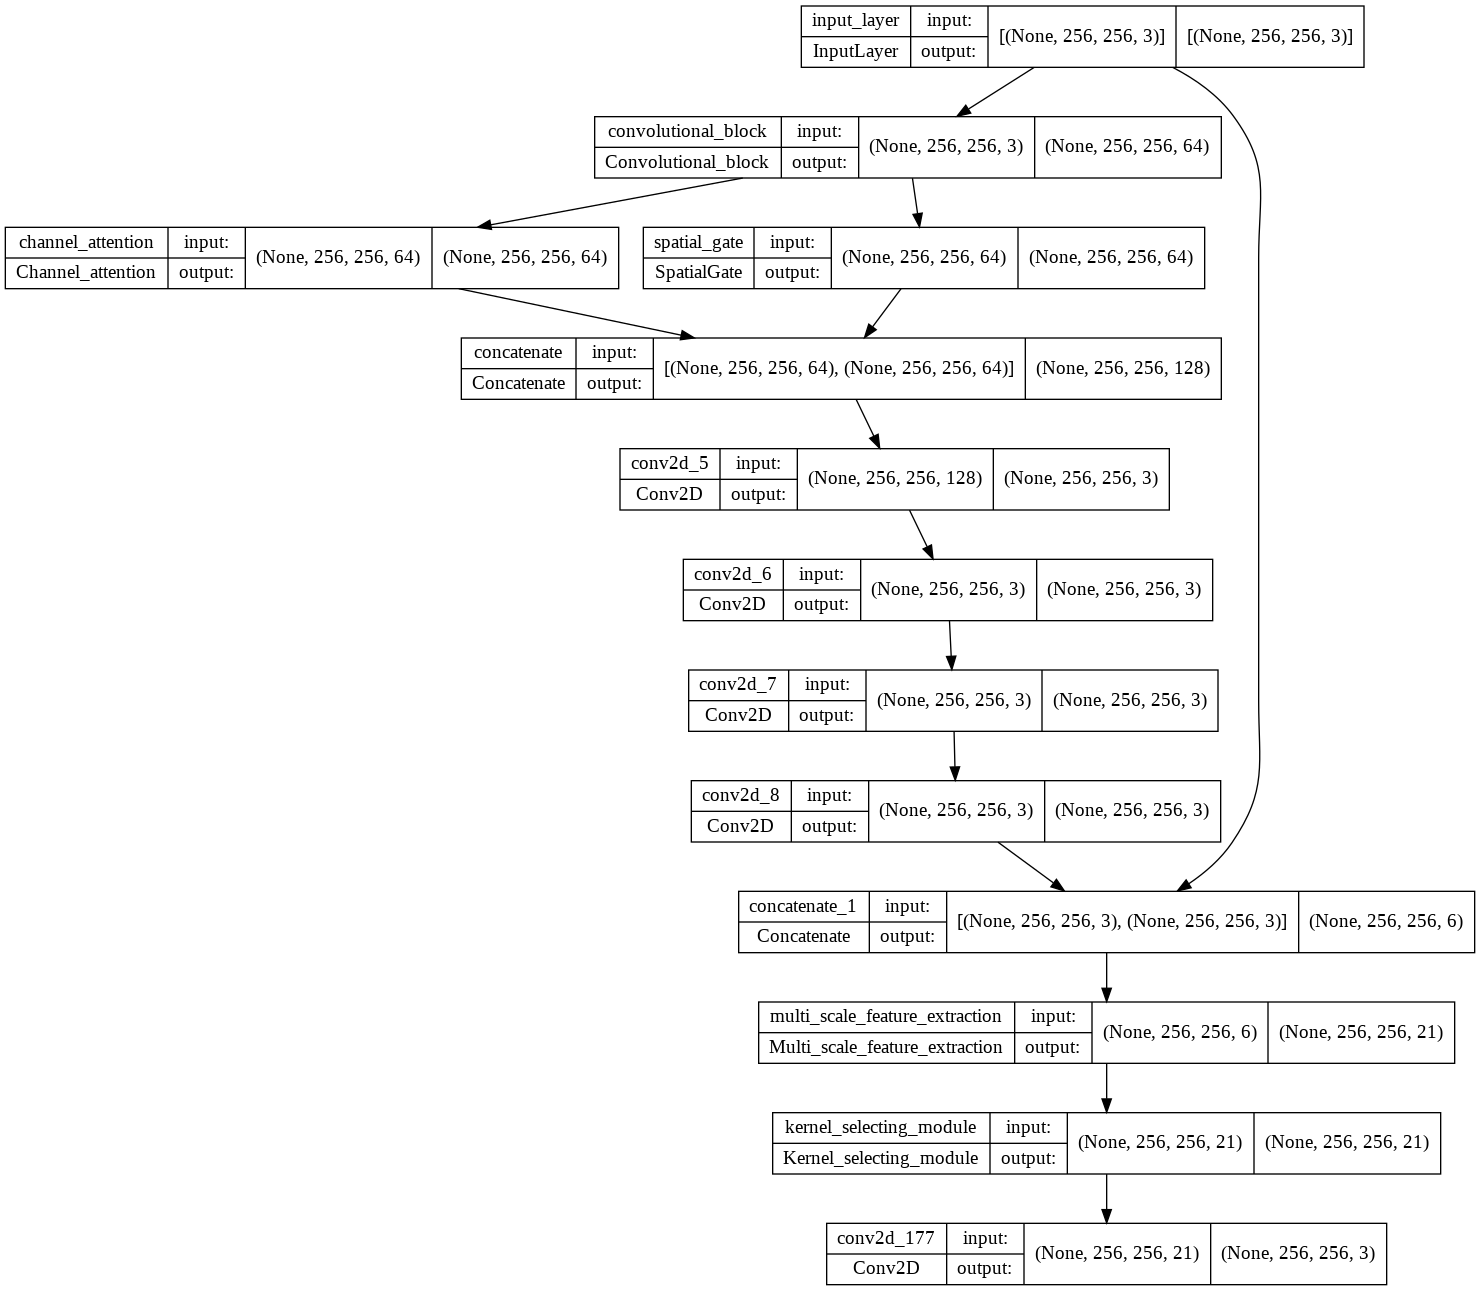

In [ ]:
tf.keras.utils.plot_model(model=model, to_file='model_plot.png', show_shapes=True)

In [ ]:
steps_per_epoch_train = len(noisy_train_images)
steps_per_epoch_validation = len(noisy_test_images)

In [ ]:
best_models_path = "/content/drive/MyDrive/Colab Notebooks/Applied AI Assignments/Case Study 2 Image Denoising/Best Models/PRIDNet model/"
callbacks_lst = [
                 tf.keras.callbacks.ModelCheckpoint(filepath=best_models_path+"variance0-01.h5", period=10, save_weights_only=False),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=0.0000009, min_delta=0.0001, factor=0.70, patience=10, verbose=1, mode='min'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.0001, patience=100)
]

In [ ]:
model.load_weights("/content/drive/MyDrive/Colab Notebooks/Applied AI Assignments/Case Study 2 Image Denoising/Best Models/PRIDNet model/variance0-01.h5")

In [ ]:
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=Adam(learning_rate=0.0009))
model.fit(image_generator_train, 
          validation_data=image_generator_test,
                        steps_per_epoch=steps_per_epoch_train,
                        validation_steps=steps_per_epoch_validation,
                        initial_epoch = 420,
                        epochs=520,
                        verbose=1,
                        callbacks=callbacks_lst)

Epoch 421/520
---conv block= (4, 256, 256, 64)
--------------------ap = (4, 16, 16, 6)
--------------------unet (4, 16, 16, 3)
-------------------upsample shape (4, 256, 256, 3)
--------------------ap = (4, 32, 32, 6)
--------------------unet (4, 32, 32, 3)
-------------------upsample shape (4, 256, 256, 3)
--------------------ap = (4, 64, 64, 6)
--------------------unet (4, 64, 64, 3)
-------------------upsample shape (4, 256, 256, 3)
--------------------ap = (4, 128, 128, 6)
--------------------unet (4, 128, 128, 3)
-------------------upsample shape (4, 256, 256, 3)
--------------------ap = (4, 256, 256, 6)
--------------------unet (4, 256, 256, 3)
-------------------upsample shape (4, 256, 256, 3)
---Multi scale feature extraction block= (4, 256, 256, 21)
(4, 3, 1, 21)
Tensor("model/kernel_selecting_module/strided_slice:0", shape=(4, 1, 21), dtype=float32)
Tensor("model/kernel_selecting_module/Reshape_1:0", shape=(4, 1, 1, 21), dtype=float32)
---conv block= (4, 256, 256, 64)
-------

In [ ]:
visualize_predictions(model, noisy_test_images, gt_test_images, 1)

In [ ]:
from skimage.metrics import peak_signal_noise_ratio
from google.colab import files

predicted_images = inference_batch_images(model, noisy_test_images)
#fig.savefig("predicted_images.png")
  
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images, noisy_test_images, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images.shape[0]
psnr_prediction_mean/=gt_test_images.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

In [ ]:
from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images, noisy_test_images, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images.shape[0]
ssim_prediction_mean/=gt_test_images.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)

In [ ]:
import numpy as np

def mse(actual,prediction):
    return np.square(np.subtract(actual,prediction)).mean()

#define Actual and Prediction data array

actual = gt_test_images
pred = predicted_images
noisy = noisy_test_images

#Calculate MSE
result1 = mse(actual,noisy)
result = mse(actual,pred)

#print the result
print("Mean squared error (MSE) of ground truth and noisy:", result1)
print("Mean squared error (MSE) of ground truth and predicted:", result)

In [ ]:
import tensorflow as tf

images = pred

for i, image in enumerate(images, 1):
    tf.keras.preprocessing.image.save_img(f'output_0.01.png', image)

In [ ]:
def EPI_Measure(I, Ihat):
    """Measure of edge preservation index as defined in Coupé et al.
    
    Parameters
    ----------
    I: array
        Input 2D array of noiseless image.
    I_hat: array
        Input 1D array of filtered image.
        
    Return
    ------
    EPI: float
        Edge preservation index of filtered image.
        
    References
    ----------
        COUPÉ, P.; MANJÓN, J. V.; ROBLES, M.; COLLINS, D. L. Adaptive
        multiresolution non-local means filter for three-dimensional magnetic resonance
        image denoising. IET Image Processing, [S. l.], v. 6, n. 5, p. 558, 2012. DOI:
        10.1049/iet-ipr.2011.0161. Available at: https://digitallibrary.theiet.org/content/journals/10.1049/iet-ipr.2011.0161.
    """

    laplacian_kernel = np.array([[[0, 0, 0],[0, 1, 0], [0, 0, 0]],
                                [[0, 1, 0],[1, -6, 1],[0, 1, 0]],
                                [[0, 0, 0],[0, 1, 0], [0, 0, 0]]])

    lap_I = convolve(I, laplacian_kernel)
    lap_Ihat = convolve(Ihat, laplacian_kernel)

    mean_lap_I = np.mean(lap_I)
    mean_lap_Ihat = np.mean(lap_Ihat)

    n = np.sum((lap_I-mean_lap_I)*(lap_Ihat-mean_lap_Ihat))
    d = np.sqrt(np.sum((lap_I-mean_lap_I)**2)*
            np.sum((lap_Ihat-mean_lap_Ihat)**2)) 
    
    EPI = n/d
    return EPI

In [ ]:
###0.1 variance